In [18]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

## Separação de dados

In [19]:
dados = pd.read_csv("data/Vehicle.csv")
# shuffle data to avoid bias
dados = shuffle(dados)

# transform the last collumn into integer values
le = LabelEncoder()
le.fit(dados["Class"])
dados["Class"] = le.transform(dados["Class"])

df_dados = pd.DataFrame(dados)

# print which class each integer value represents
print("Encoded Classes:")
print(le.classes_)

# shuffle the data and split it into train, validation and test sets

x_treino, x_temp, y_treino, y_temp = train_test_split(
    df_dados, df_dados["Class"], test_size=0.5, stratify=df_dados["Class"]
)
x_validacao, x_teste, y_validacao, y_teste = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp
)

print("Treino")
x_treino.info()
y_treino.info()

# print("\nValidação")
# x_validacao.info()
# y_validacao.info()

# print("\nTeste")
# x_teste.info()
# y_teste.info()

Encoded Classes:
['bus' 'opel' 'saab' 'van']
Treino
<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 300 to 345
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   A1      423 non-null    int64
 1   A2      423 non-null    int64
 2   A3      423 non-null    int64
 3   A4      423 non-null    int64
 4   A5      423 non-null    int64
 5   A6      423 non-null    int64
 6   A7      423 non-null    int64
 7   A8      423 non-null    int64
 8   A9      423 non-null    int64
 9   A10     423 non-null    int64
 10  A11     423 non-null    int64
 11  A12     423 non-null    int64
 12  A13     423 non-null    int64
 13  A14     423 non-null    int64
 14  A15     423 non-null    int64
 15  A16     423 non-null    int64
 16  A17     423 non-null    int64
 17  A18     423 non-null    int64
 18  Class   423 non-null    int64
dtypes: int64(19)
memory usage: 66.1 KB
<class 'pandas.core.series.Series'>
Int64Index: 423 entries, 300 t

In [20]:
def plot_roc_curve(fper, tper,cor,classsificador):
    plt.plot(fper, tper, color=cor, label=classsificador)
    plt.plot([0, 1], [0, 1], color="green", linestyle='--')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend()

# KNN


Desempenho do KNN
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        55
           1       0.36      0.36      0.36        53
           2       0.44      0.33      0.37        55
           3       0.75      0.88      0.81        49

    accuracy                           0.58       212
   macro avg       0.57      0.59      0.58       212
weighted avg       0.57      0.58      0.57       212

AUC KNN:  0.7298784018529242


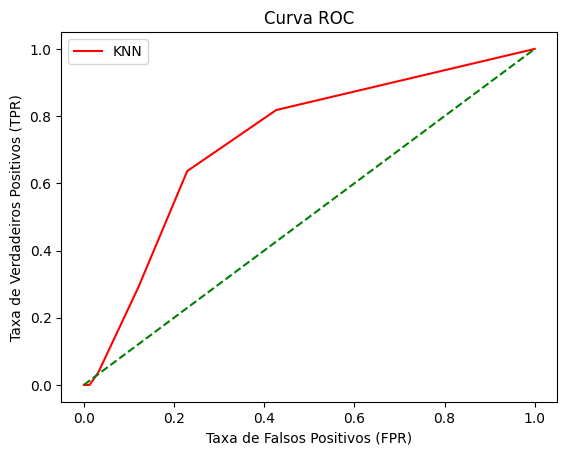

In [21]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=5)

KNN.fit(x_treino,y_treino)

knn_predict_test = KNN.predict(x_teste)

print("\nDesempenho do KNN")
print(classification_report(y_teste,knn_predict_test))

y_score = KNN.predict_proba(x_teste)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_teste,y_score,pos_label=2)

print("AUC KNN: ",metrics.auc(fpr,tpr))
plot_roc_curve(fpr, tpr,"red","KNN")


# Árvore de Decisão


Desempenho da Árvore de Decisão
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00        49

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212

AUC DT:  0.3312101910828026


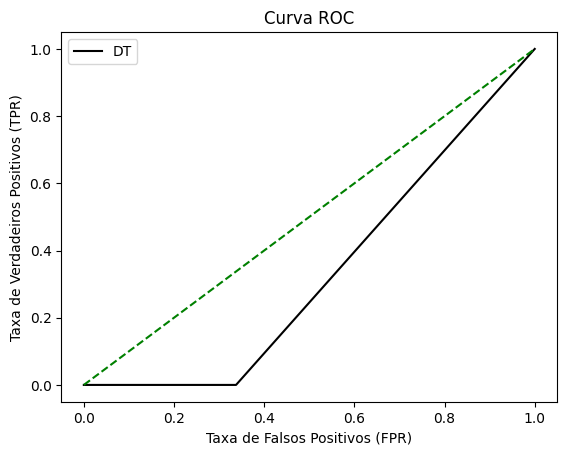

In [22]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(x_treino,y_treino)

dt_predict_test = DT.predict(x_teste)

print("\nDesempenho da Árvore de Decisão")
print(classification_report(y_teste,dt_predict_test))

y_score = DT.predict_proba(x_teste)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_teste,y_score,pos_label=2)

print("AUC DT: ",metrics.auc(fpr,tpr))
plot_roc_curve(fpr, tpr,"black","DT")

# Naive Bayes


Desempenho do Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        55
           3       1.00      1.00      1.00        49

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212

AUC NB:  0.3312101910828026


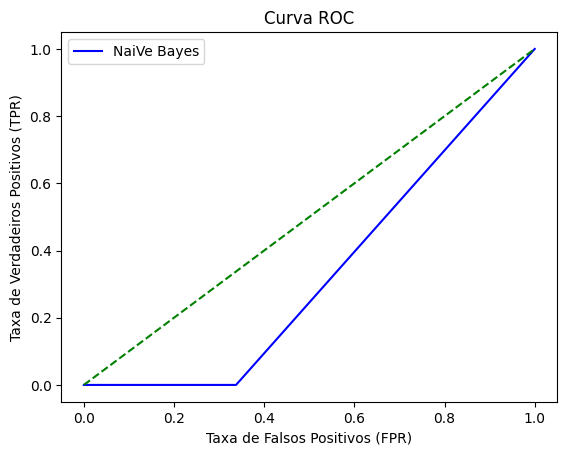

In [23]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(x_treino,y_treino)

nb_predict_test = NB.predict(x_teste)

print("\nDesempenho do Naive Bayes")
print(classification_report(y_teste,nb_predict_test))

y_score = NB.predict_proba(x_teste)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_teste,y_score,pos_label=2)

print("AUC NB: ",metrics.auc(fpr,tpr))
plot_roc_curve(fpr, tpr,"blue","NaiVe Bayes")

# SVM


Desempenho do SVM
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.98      0.96      0.97        53
           2       1.00      0.96      0.98        54
           3       0.96      1.00      0.98        50

    accuracy                           0.98       211
   macro avg       0.98      0.98      0.98       211
weighted avg       0.98      0.98      0.98       211

AUC SVM:  0.4264041690793284


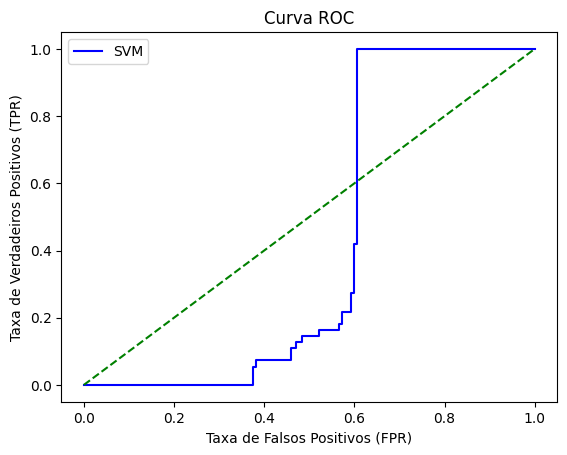

In [24]:
from sklearn.svm import SVC

SVM = SVC(kernel="linear", probability=True)
SVM.fit(x_treino, y_treino)

svm_pred_validation = SVM.predict(x_validacao)

print("\nDesempenho do SVM")
print(classification_report(y_validacao, svm_pred_validation))

y_score = SVM.predict_proba(x_teste)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_teste, y_score, pos_label=2)

print("AUC SVM: ", metrics.auc(fpr, tpr))
plot_roc_curve(fpr, tpr, "blue", "SVM")

# MLP


Desempenho do SVM
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.98      0.96      0.97        53
           2       1.00      0.96      0.98        54
           3       0.96      1.00      0.98        50

    accuracy                           0.98       211
   macro avg       0.98      0.98      0.98       211
weighted avg       0.98      0.98      0.98       211

AUC MLP:  0.4264041690793284


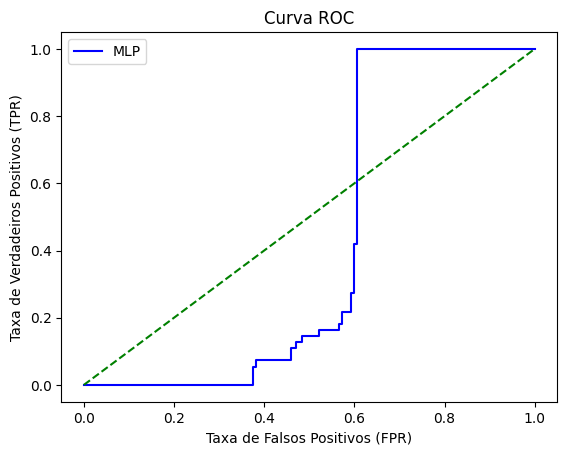

In [25]:
from sklearn.neural_network import MLPClassifier

# Create an instance of the MLP classifier
MLP = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
MLP.fit(x_treino, y_treino)

mlp_pred_validation = MLP.predict(x_validacao)

print("\nDesempenho do SVM")
print(classification_report(y_validacao, svm_pred_validation))

y_score = SVM.predict_proba(x_teste)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_teste, y_score, pos_label=2)

print("AUC MLP: ", metrics.auc(fpr, tpr))
plot_roc_curve(fpr, tpr, "blue", "MLP")
